# Ryan Tschritter

## Research Questions / Interests

1. **How are the statistics correlated in each season and between both seasons?**

2. **Will a player with better offensive statistics in 2017 receive more time on ice in the next season? Does the coach give them more time on ice?**

3. **Does a players positive offensive performance in the previous season lead to more penalty time / body checks in the next season? Do they develop a ego?**

## Analysis Plan

Question 1
1. Generate correlation matrix for all columns of data in each dataset and combined datasets

Question 2
1. Combine all positive statistics into a single statistic by normalizing each statistic and then adding all the normalizations together into a single score.
2. Compare this single normalized score to the time on ice in the next season and visualize the trends.

Question 3
1. Take the single normalized score from question 2 and compare it to the penalty time in the next season.

## Analysis Pipeline
---

In [1]:
# Import Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
import importlib
sys.path.append('..')
from analysis.code import project_functions3 as pf3
importlib.reload(pf3) # Forcing a reload of the function because it was running a old verion in memory

# Method chaining function
nhlMerged = pf3.load_and_merge3('../data/processed/Data301ProjectData2017.csv', '../data/processed/Data301ProjectData2018.csv')

In [3]:
# Import Merged Dataset with sufixes
#nhlMerged = pd.read_csv('../data/processed/merged.csv')

In [4]:
#Import Individual Datasets
nhl2017 = pd.read_csv('../data/processed/clean2017.csv')
nhl2018 = pd.read_csv('../data/processed/clean2018.csv')

In [5]:
# View the shape of the dataframes (ie. the number of columns and rows)
fstring1 = f"The shape of the 2017 dataframe is {nhl2017.shape}."
fstring2 = f"The shape of the 2018 dataframe is {nhl2018.shape}."
fstring3 = f"The shape of the merged dataframe is {nhlMerged.shape}."
print(fstring1)
print(fstring2)
print(fstring3)

The shape of the 2017 dataframe is (225, 19).
The shape of the 2018 dataframe is (225, 19).
The shape of the merged dataframe is (225, 37).


In [6]:
# Check to make sure the 2017 names match the 2018 names
print(nhl2017['Name'].equals(nhl2018['Name']))
print(nhlMerged['Name'].equals(nhl2018['Name']))

True
True


In [7]:
# Python dictionary for column titles
legend = {
    'Rk':'Rank In List', # The order when the data was exported from the website
    'GP':'Games Played', # The number of games played in the season
    'G':'Goals Scored', # The total number of goals scored in the season
    'A':'Assists', # The number of assists in the season
    'P':'Points', # Goals plus assists equals points
    'PIM':'Penalty Minutes', # Total number of minutes spent in the penalty box
    '+/-':'Plus Minus', # Tracks difference in goals scored when on ice, plus one when a goal is scored, minus one when a opposing team scores
    'TOI':'Average Time on Ice', # The average time on ice per game
    'PPG':'Power-Play Goals', # Number of goals score by a player when team has a power play
    'GWG':'Game-Winning Goals', # The player that scored the final goal of the game (total cumulative)
    'PPP':'Power-Play Points', # Players own power play points, positively correlated with power play goals and power play assists
    'G/GP':'Goals Per Game Played', # Goals per game played accounts for players that haven't played every game
    'A/GP':'Assists Per Game Played', # Assists per game played accounts for players that haven't played every game
    'P/GP':'Points Per Game Played', # Points per game played accounts for players that haven't played every game
    'SHOTS':'Shots On Goal', # Number of attempted shots on goal
    'SH%':'Shot Percentage', # Percent of shots that are goals
    'HITS':'Hits', # Number of body checks performed on the opposing team puck carrier
    'BS':'Blocked Shots' # Number of shots blocked by a player
}

# Exploratory Data Analysis
---

In [8]:
nhl2017.head(3)

,Rk,Name,GP,G,A,P,PIM,+/-,TOI,PPG,GWG,PPP,G/GP,A/GP,P/GP,SHOTS,SH%,HITS,BS
0,185,Aaron Ekblad,82,16,22,38,71,9,23:22,5,4,11,0.195,0.268,0.463,189,8.50%,69,121
1,115,Adam Henrique,81,24,26,50,20,11,17:46,6,8,13,0.296,0.321,0.617,151,15.90%,61,61
2,193,Adrian Kempe,81,16,21,37,49,11,13:19,1,3,5,0.198,0.259,0.457,119,13.50%,91,18


In [9]:
nhlMerged.head(3)

,Name,Rk_2017,GP_2017,G_2017,A_2017,P_2017,PIM_2017,+/-_2017,TOI_2017,PPG_2017,...,PPG_2018,GWG_2018,PPP_2018,G/GP_2018,A/GP_2018,P/GP_2018,SHOTS_2018,SH_2018,HITS_2018,BS_2018
0,Aaron Ekblad,185,82,16,22,38,71,9,1402,5,...,5,1,10,0.159,0.293,0.451,180,7.2,114,88
1,Adam Henrique,115,81,24,26,50,20,11,1066,6,...,8,3,13,0.220,0.293,0.512,122,14.8,78,71
2,Adrian Kempe,193,81,16,21,37,49,11,799,1,...,0,2,4,0.148,0.198,0.346,118,10.2,86,21


In [10]:
nhlMerged.describe().T

,count,mean,std,min,25%,50%,75%,max
Rk_2017,225.0,119.337778,71.573274,1.000,57.000,119.000,179.000,250.000
GP_2017,225.0,76.871111,6.997213,44.000,74.000,80.000,82.000,82.000
G_2017,225.0,20.382222,8.879935,5.000,14.000,19.000,25.000,49.000
A_2017,225.0,32.933333,12.503571,13.000,23.000,31.000,41.000,68.000
P_2017,225.0,53.315556,16.995876,32.000,40.000,49.000,64.000,108.000
PIM_2017,225.0,33.915556,20.680973,2.000,20.000,30.000,43.000,187.000
+/-_2017,225.0,2.457778,14.962430,-42.000,-6.000,2.000,11.000,49.000
TOI_2017,225.0,1118.088889,180.818331,747.000,988.000,1087.000,1208.000,1609.000
PPG_2017,225.0,5.413333,3.718054,0.000,3.000,5.000,7.000,20.000
GWG_2017,225.0,3.324444,2.174646,0.000,2.000,3.000,4.000,12.000


[(0.0, 55.0)]

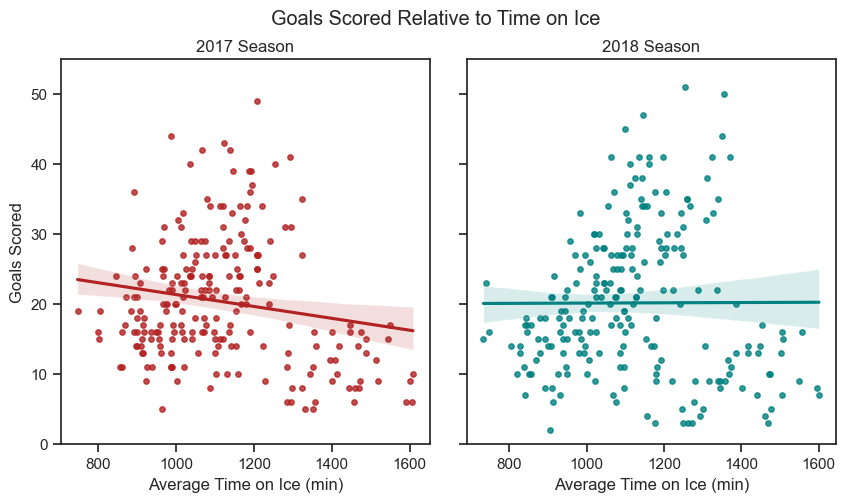

In [11]:
# Plot 1 
sns.set(style = 'ticks')
plot1, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
plot1.suptitle('Goals Scored Relative to Time on Ice')
plot1.subplots_adjust(wspace=0.1)
sns.regplot(ax=axes[0], data = nhlMerged, x = "TOI_2017", y = "G_2017", color = "firebrick", scatter_kws={'s':15})
sns.regplot(ax=axes[1], data = nhlMerged, x = "TOI_2018", y = "G_2018", color = "teal", scatter_kws={'s':15})
axes[0].set(title='2017 Season', xlabel=legend['TOI']+' (min)', ylabel=legend['G'])
axes[1].set(title='2018 Season', xlabel=legend['TOI']+' (min)', ylabel='')
axes[0].set(ylim=(0,55))

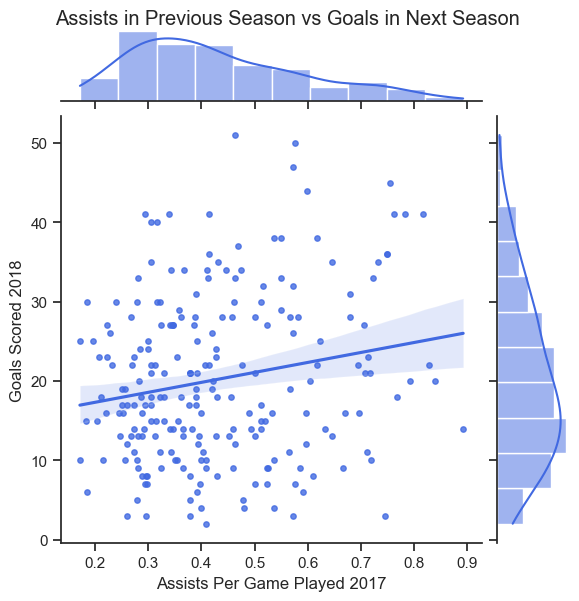

In [12]:
# Plot 2
sns.set(style = 'ticks')
plot2 = sns.jointplot(data=nhlMerged, x = "A/GP_2017", y = "G_2018", kind = "reg", color = "royalblue", scatter_kws={'s':15})
plot2.set_axis_labels(xlabel=legend['A/GP']+' 2017', ylabel=legend['G']+' 2018')
plt.suptitle('Assists in Previous Season vs Goals in Next Season', y=1)
sns.set(font_scale=1)

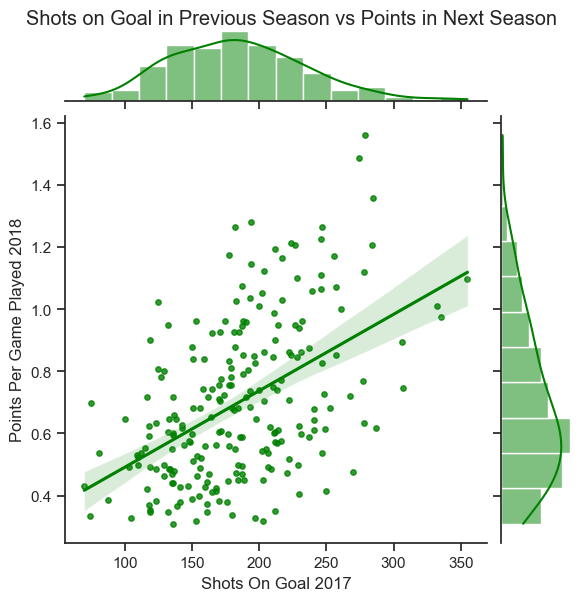

In [13]:
# Plot 3
sns.set(style = 'ticks')
plot3 = sns.jointplot(data=nhlMerged, x = "SHOTS_2017", y = "P/GP_2018", kind = "reg", color = "green", scatter_kws={'s':15})
plot3.set_axis_labels(xlabel=legend['SHOTS']+' 2017', ylabel=legend['P/GP']+' 2018')
plt.suptitle('Shots on Goal in Previous Season vs Points in Next Season', y=1)
sns.set(font_scale=1)

## Notes about Exploratory Data Analysis

- The goals scored relative to time on ice graphs showed that there isn't a direct correlation between time on ice and the number of goals a player scores, perhaps this is because they become exhausted or fatigued.
- The assists in a previous season vs the goals in the next season showed a positive correlation, however this may also be due to players who score better also have more assists.
- Shots on goal in the previous season had a strong correlation with points in the next season, perhaps because players that consistently shoot more shots on goal will continue to do so in the next season leading to goals and assists which equal points.

# Data Analysis

## Analysis Question 1

### Lets begin with correlation matrices for all three datasets (2017, 2018 and merged)

In [14]:
# Create a reduced dataframe to find significant correlations
reduced2017 = nhl2017[['GP','P','PIM','TOI','PPP','P/GP','SHOTS']]
reduced2018 = nhl2018[['GP','P','PIM','TOI','PPP','P/GP','SHOTS']]
reducedmerg = nhlMerged[['GP_2017','P_2017','PIM_2017','TOI_2017','PPP_2017','P/GP_2017','SHOTS_2017',
                         'GP_2018','P_2018','PIM_2018','TOI_2018','PPP_2018','P/GP_2018','SHOTS_2018']]

reduced2017 = reduced2017.corr(numeric_only=True).round(3)
reduced2018 = reduced2018.corr(numeric_only=True).round(3)
reducedmerg = reducedmerg.corr(numeric_only=True).round(3)

reducedmerg = reducedmerg.iloc[7:14, 0:7] # Trim it down to the bottom left of the dataframe

plotmask2017 = np.triu(np.ones_like(reduced2017, dtype=bool), k=1)
plotmask2018 = np.triu(np.ones_like(reduced2018, dtype=bool), k=1)
#plotmaskmerg = np.triu(np.ones_like(reducedmerg, dtype=bool), k=1)

[Text(0.5, 1.0, '2018 Season')]

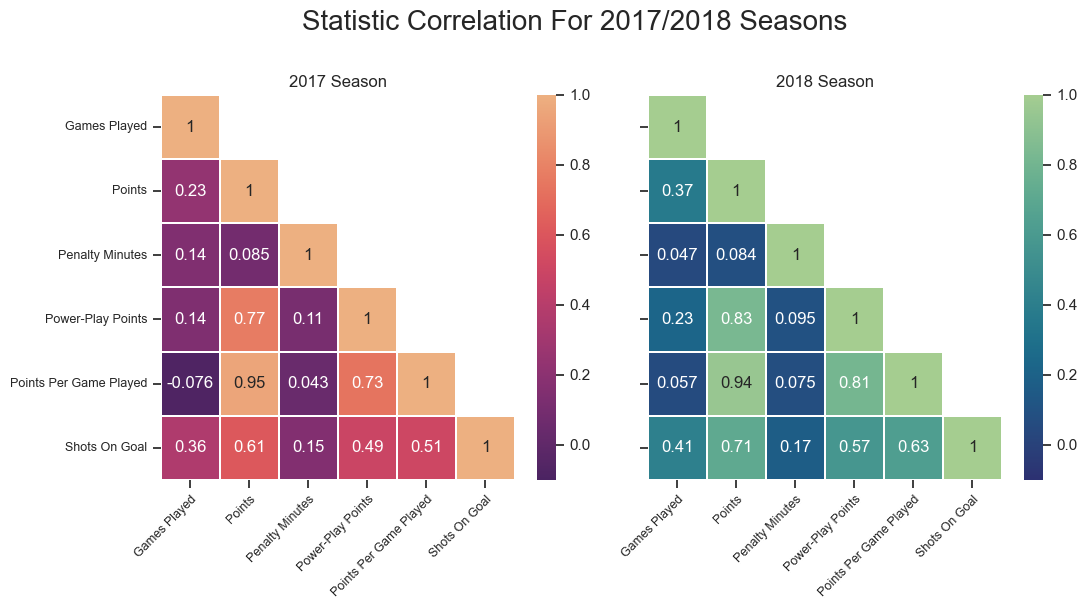

In [15]:
# Plot 4
sns.set(style = 'ticks')
plot4, axes = plt.subplots(1, 2, figsize=(12,5), sharey=False)
plot4.suptitle('Statistic Correlation For 2017/2018 Seasons', size=20, x=0.47, y=1.05)
plot4.subplots_adjust(wspace=0.1)

sns.heatmap(ax=axes[0], data=reduced2017, annot=True, linewidths=0.1, mask=plotmask2017, cmap='flare_r', vmin=-.1, vmax=1)
sns.heatmap(ax=axes[1], data=reduced2018, annot=True, linewidths=0.1, mask=plotmask2018, cmap='crest_r', vmin=-.1, vmax=1)

tickLabels = []
for i in list(reduced2017.columns):
    tickLabels.append(legend[i])

axes[0].set_xticklabels(labels=tickLabels, rotation=45, ha='right', rotation_mode='anchor')
axes[0].set_yticklabels(labels=tickLabels, rotation=0, ha='right', rotation_mode='anchor')
axes[1].set_xticklabels(labels=tickLabels, rotation=45, ha='right', rotation_mode='anchor')
axes[1].set_yticklabels(labels='')
axes[0].tick_params(axis='both', which='major', labelsize=9)
axes[1].tick_params(axis='both', which='major', labelsize=9)

axes[0].set(title='2017 Season')
axes[1].set(title='2018 Season')

### Analysis Of The Correlation Matrices For 2017 And 2018 (Shown Above)

These plots show the two seasons and the correlation of variables within each of the seasons independently. From this plot we can draw a few conclusions. First off, there are some highly correlated variables such as the points and points per game played. This makes sense as if a player is scoring higher points then they should be getting high points per game. However this correlation doesn't say much about the players performance. Looking at other correlations such as the points per game played and shots on goal, its easier to draw a conclusion because a player with more shots on goal will probably also have higher points (goals & assists) per game played leading to a high correlation.

---

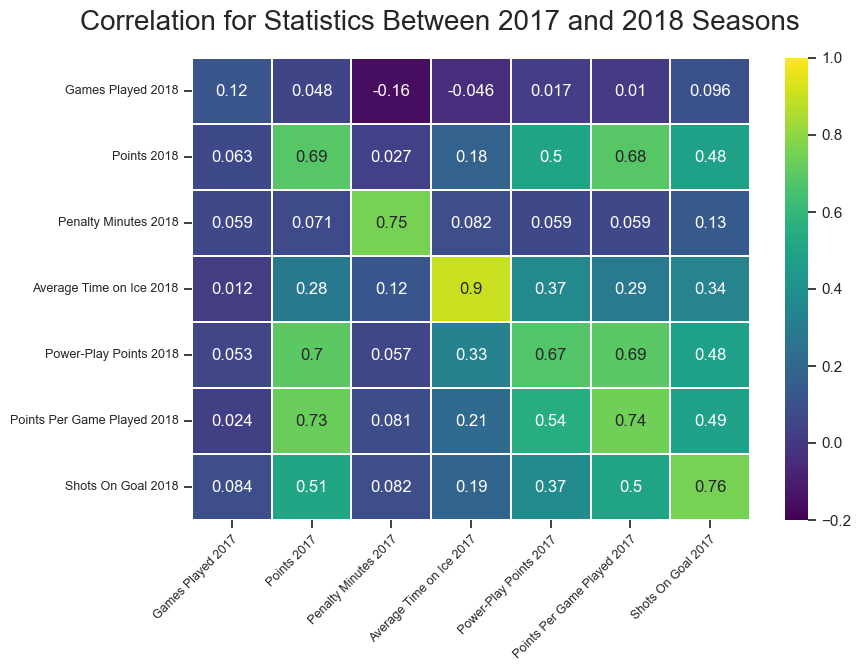

In [16]:
# Plot 5
sns.set(style = 'ticks')
plot5, axes = plt.subplots(figsize=(9,6))
plot5.suptitle('Correlation for Statistics Between 2017 and 2018 Seasons', size=20, x=0.4, y=0.96)
sns.set(font_scale=1)
sns.heatmap(data=reducedmerg, annot=True, linewidths=0.1, cmap='viridis', vmin=-.2, vmax=1)

tickLabels2 = []
for i in list(reducedmerg.columns):
    splitList = i.split('_', 1)
    tickLabels2.append(legend[splitList[0]]+" "+splitList[1])
    
tickLabels3 = []
for i in list(reducedmerg.index):
    splitList = i.split('_', 1)
    tickLabels3.append(legend[splitList[0]]+" "+splitList[1])
    
axes.set_xticklabels(labels=tickLabels2, rotation=45, ha='right', rotation_mode='anchor')
axes.set_yticklabels(labels=tickLabels3, rotation=0, ha='right', rotation_mode='anchor')
axes.tick_params(axis='both', which='major', labelsize=9)

### Analysis Of The Correlation Matrices Merged Seasons (Shown Above)

From the graphs above we find that there are a few categories that are significantly corelated such as the points and points per games played for both seasons, the time on ice for both seasons and the power play points with the regular points. All of the mentioned statistics are all inherently correlated meaning they are expected to have similar values and not be statistically significant. Some other statistics however we're not inherently correlated and still showed a correlation such as the shots on goal in 2017 and the points in 2018. I think what this chart revels however is that players who perform better will consistently perform better, leading to very little correlations between unrelated statistics.

---

## Analysis Question 2

### Start by creating a normalized score for the 'positive' offensive statistics for a players performance in 2017

The 'positive' statistics I'll be combining into a normalized value will be:
- Points (Combination of Goals and Assists)
- Power Play Points
- Shots on Goal
- Game winning goals
- Shot Percentage

In [17]:
# Normalization Formula = x - xmin / xmax - xmin
nhlMerged['norm_P_2017'] = nhlMerged['P_2017'].apply(lambda x: (x-nhlMerged['P_2017'].min()) / (nhlMerged['P_2017'].max()-nhlMerged['P_2017'].min()) )
nhlMerged['norm_PPP_2017'] = nhlMerged['PPP_2017'].apply(lambda x: (x-nhlMerged['PPP_2017'].min()) / (nhlMerged['PPP_2017'].max()-nhlMerged['PPP_2017'].min()) )
nhlMerged['norm_SHOTS_2017'] = nhlMerged['SHOTS_2017'].apply(lambda x: (x-nhlMerged['SHOTS_2017'].min()) / (nhlMerged['SHOTS_2017'].max()-nhlMerged['SHOTS_2017'].min()) )
nhlMerged['norm_GWG_2017'] = nhlMerged['GWG_2017'].apply(lambda x: (x-nhlMerged['GWG_2017'].min()) / (nhlMerged['GWG_2017'].max()-nhlMerged['GWG_2017'].min()) )
nhlMerged['norm_SH_2017'] = nhlMerged['SH_2017'].apply(lambda x: (x-nhlMerged['SH_2017'].min()) / (nhlMerged['SH_2017'].max()-nhlMerged['SH_2017'].min()) )


[Text(0.5, 0, 'Normalized Distribution')]

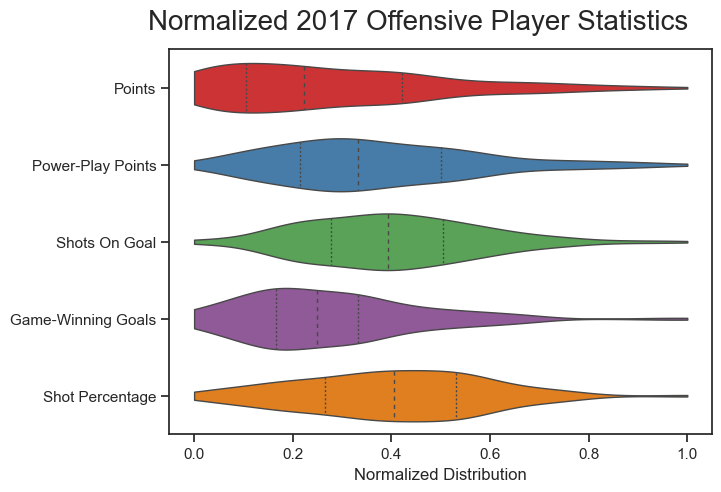

In [18]:
# Plot 6
sns.set(style = 'ticks')
plot6, axes = plt.subplots(figsize=(7,5))
plot6.suptitle('Normalized 2017 Offensive Player Statistics', size=20, x=0.48, y=0.96)
sns.set(font_scale=0.8)
sns.violinplot(data=nhlMerged[['norm_P_2017', 'norm_PPP_2017', 'norm_SHOTS_2017', 'norm_GWG_2017', 'norm_SH_2017']], 
               inner='quartile', 
               orient='h',
               linewidth=1,
               palette='Set1',
               cut=0)
axes.set_yticklabels(labels=[legend['P'],legend['PPP'],legend['SHOTS'],legend['GWG'],legend['SH%']])
axes.set(xlabel='Normalized Distribution')

### Analysis Of The Normalization of Offensive Player Statistics (Shown Above)

After normalizing all 5 of these statistics from the 2017 dataset, I've plotted their normalized values in a violin chart shown above. This chart does a good job showing that the majority of player statistics fall below the 0.5 mark meaning there are some players that perform exceptionally well in certain categories/statistics.

In [19]:
# Combine all the normalized values into a single value ranging from 0 to 5
nhlMerged['norm_total_2017'] = nhlMerged['norm_P_2017'] + nhlMerged['norm_PPP_2017'] + nhlMerged['norm_SHOTS_2017'] +nhlMerged['norm_GWG_2017'] + nhlMerged['norm_SH_2017']

[Text(0.5, 0, 'Summed Normalized Value (Possible Range: 0 to 5)'),
 Text(0, 0.5, 'Number of Occurrences')]

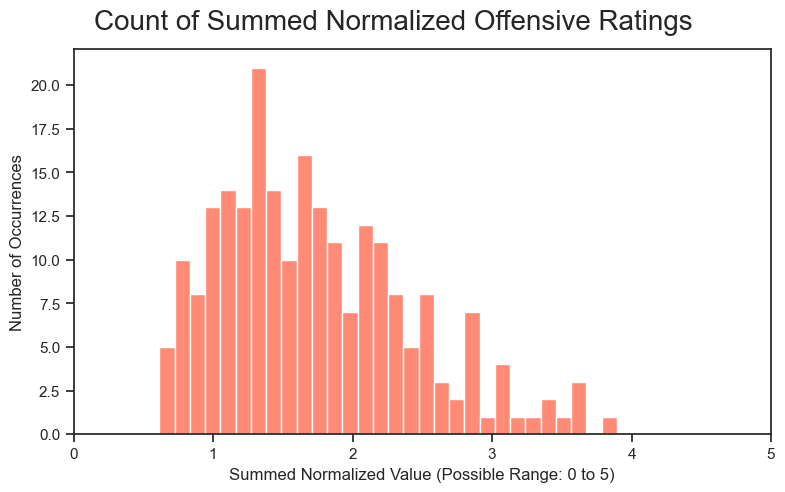

In [20]:
# Plot 7
sns.set(style = 'ticks')
plot7, axes = plt.subplots(figsize=(9,5))
plot7.suptitle('Count of Summed Normalized Offensive Ratings', size=20, x=0.48, y=0.96)
sns.set(font_scale=0.8)
sns.histplot(data=nhlMerged, x='norm_total_2017', bins=30, color='tomato', ax=axes)
axes.set_xticks(range(0,5+1))
axes.set(xlabel='Summed Normalized Value (Possible Range: 0 to 5)', ylabel='Number of Occurrences')

### Analysis Of The Summed Normalized Offensive Ratings (Shown Above)

Taking the individual normalized values and adding them together to form a score out of 5 shows again that the majority of players score in these 5 categories falls below the middle of 2.5 but there are some players that do exceptionally well and score much higher.

[Text(0.5, 0, 'Player Time on Ice 2018 (min)'),
 Text(0, 0.5, 'Residual Distance')]

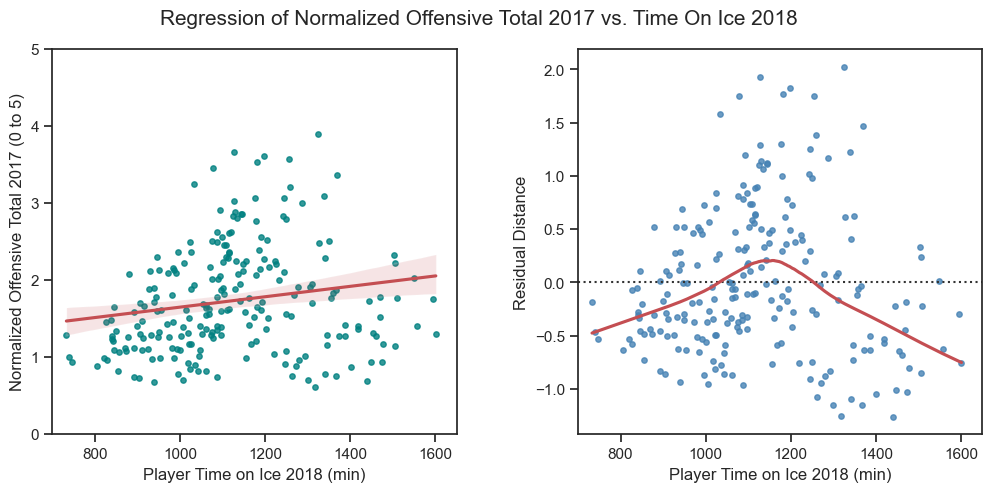

In [21]:
# Plot 8
sns.set(style = 'ticks')
plot8, axes = plt.subplots(1, 2, figsize=(12,5))
plot8.subplots_adjust(wspace=0.3)
plot8.suptitle('Regression of Normalized Offensive Total 2017 vs. Time On Ice 2018', size=15, x=0.48, y=0.96)
sns.set(font_scale=0.8)
sns.regplot(data=nhlMerged, x='TOI_2018', y='norm_total_2017', color='teal', scatter_kws={'s':15}, line_kws=dict(color='r'), ax=axes[0])
sns.residplot(data=nhlMerged, x='TOI_2018', y='norm_total_2017', color='steelblue', scatter_kws={'s':15}, lowess=True, line_kws=dict(color='r'), ax=axes[1])
axes[0].set(xlim=(700,1650))
axes[0].set(ylim=(0,5))
axes[1].set(xlim=(700,1650))
axes[0].set(xlabel='Player Time on Ice 2018 (min)', ylabel='Normalized Offensive Total 2017 (0 to 5)')
axes[1].set(xlabel='Player Time on Ice 2018 (min)', ylabel='Residual Distance')

### Analysis Of The Regression and Residual Plot (Shown Above)

Taking the normalized summed score and comparing it to the time on ice reveals a slight positive correlation between their time on ice in the next year and their performance in the previous year. This small positive correlation may mean that the coach could be giving players that perform better more time on the ice but this doesn't reveal anything about whether there is anything significant about their performance in the last year vs current year. The graph on the right shows the residual distance and shows that there’s a clear separation below the regression line on the far outliers on the time on ice but shows a positive separation in the center of the dataset causing this mountain shaped residual regression line.

[Text(0.5, 0, 'Number of Body Checks 2018'), Text(0, 0.5, 'Residual Distance')]

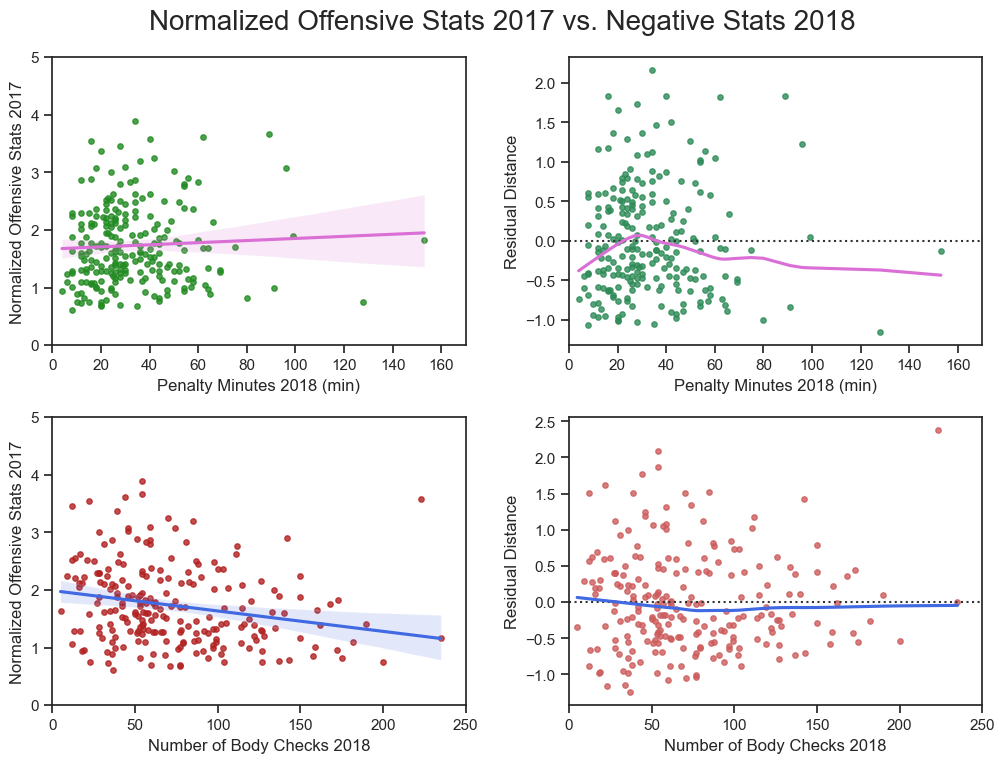

In [22]:
# Plot 9
sns.set(style = 'ticks')
plot9, ax = plt.subplots(2,2, figsize=(12,8))
plot9.subplots_adjust(top=0.92, wspace=0.25, hspace=0.25)
plot9.suptitle('Normalized Offensive Stats 2017 vs. Negative Stats 2018', size=20)
sns.set(font_scale=0.8)
sns.regplot(data=nhlMerged, x='PIM_2018', y='norm_total_2017', color='forestgreen', scatter_kws={'s':15}, line_kws=dict(color='orchid'), ax=ax[0,0])
sns.residplot(data=nhlMerged, x='PIM_2018', y='norm_total_2017', color='seagreen', scatter_kws={'s':15}, lowess=True, line_kws=dict(color='orchid'), ax=ax[0,1])
sns.regplot(data=nhlMerged, x='HITS_2018', y='norm_total_2017', color='firebrick', scatter_kws={'s':15}, line_kws=dict(color='royalblue'), ax=ax[1,0])
sns.residplot(data=nhlMerged, x='HITS_2018', y='norm_total_2017', color='indianred', scatter_kws={'s':15}, lowess=True, line_kws=dict(color='royalblue'), ax=ax[1,1])

ax[0,0].set(xlim=(0,170))
ax[0,1].set(xlim=(0,170))
ax[0,0].set(ylim=(0,5))
ax[0,0].set(xlabel='Penalty Minutes 2018 (min)', ylabel='Normalized Offensive Stats 2017')
ax[0,1].set(xlabel='Penalty Minutes 2018 (min)', ylabel='Residual Distance')

ax[1,0].set(xlim=(0,250))
ax[1,1].set(xlim=(0,250))
ax[1,0].set(ylim=(0,5))
ax[1,0].set(xlabel='Number of Body Checks 2018', ylabel='Normalized Offensive Stats 2017')
ax[1,1].set(xlabel='Number of Body Checks 2018', ylabel='Residual Distance')

### Analysis Of The Regression and Residual Plot (Shown Above)

The four graphs above have the same layout as in question 2, where the normalized summed score for offensive statistics are plotted against the number of penalty minutes and body checks. My goal was to see if a player who performed well might develop a ego and become more aggressive. However these plots reveal that the opposite might be true and that players with better offensive stats might be less prone to aggressive behavior and more focused on the game. With the penalty minutes and number of body checks showing a neutral or negative correlation.

## Summary of Analysis

From the graphs generated above we may be able to conclude that players that are better at hockey generally are better and don't change between seasons. We can also conclude that the more time a player spends on the ice they may perform better in offensive statistics, and finally players that have better offensive statistics in a previous season may actually become less aggressive in the next season. However with all these conclusions one key factor in my analysis remains, and that is that this dataset only includes two hockey seasons. In order to spot more trends it may be necessary to perform the same analysis but on multiple seasons in order to draw more conclusive trends.

In [23]:
# Export csv for dashboard
#nhlMerged.to_csv('../data/processed/analysis3export.csv')